# Pinball loss-guided LSTM

### 1. Load libraries

In [ ]:
# Libraries
import numpy as np
from pandas import DataFrame
from math import sqrt
from numpy import split, concatenate
from numpy import array , hstack
from pandas import read_csv
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import Dropout
import time
import keras.backend as K
import pickle # load and save data

from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')


import matplotlib as mpl
%matplotlib inline

### 2. Load data
#### Consumption data

In [ ]:
# Include the location where the data is stored
data_source = ''

# Load consumption Data
df_consumption = pd.read_csv("{}/consumption_prepared.csv".format(data_source), sep=",", decimal = ',')
df_consumption['consumption'] = df_consumption['consumption'].astype(float)
df_consumption.set_index('date', inplace=True)

#### Weather data

In [ ]:
# Load weather Data
df_weather = pd.read_csv('{}/daily_weather_avg.csv'.format(data_source), sep=",", decimal = '.')
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [ ]:
# subset to 2018
df_weather[['temp', 'wind', 'cloud']] = df_weather[['temp', 'wind', 'cloud']].shift(+1) # each day gets informaiton on weather the day before
df_weather_shift = df_weather.iloc[1:, :]

# Compute 24*4 weather records per day
df_weather_rep = DataFrame()
for i in range(3):
    temp = pd.Series(df_weather_shift.iloc[:,1+i])
    rep = temp.repeat(96)
    df_weather_rep[i] = rep
df_weather_rep.columns = ['temp', 'wind', 'cloud']

#### Add date-time information to the weather dataset

In [ ]:
# add date information
def compute_weekend(row):
    if row['weekday'] > 4:
        return True
    else:
        return False

In [ ]:
df_weather_rep['date'] = pd.date_range(start = '2018-01-01 00:00:00', periods = 43680, freq = '15T')
df_weather_rep.set_index('date', inplace=True)

In [ ]:
df_weather_rep.loc[:,'month'] = df_weather_rep.index.month
df_weather_rep.loc[:,'day'] = df_weather_rep.index.day
df_weather_rep.loc[:,'hour'] = df_weather_rep.index.hour
df_weather_rep['weekday']= df_weather_rep.index.weekday
df_weather_rep['is_weekend'] = df_weather_rep.apply (lambda row:compute_weekend(row), axis = 1)

In [ ]:
df_weather_rep.drop(df_weather_rep.columns[[6]], axis=1, inplace=True) # 6 position weekday column

In [ ]:
df_weather_rep

,temp,wind,cloud,month,day,hour,is_weekend
date,,,,,,,
2018-01-01 00:00:00,11.566667,8.966667,0.954167,1,1,0,False
2018-01-01 00:15:00,11.566667,8.966667,0.954167,1,1,0,False
2018-01-01 00:30:00,11.566667,8.966667,0.954167,1,1,0,False
2018-01-01 00:45:00,11.566667,8.966667,0.954167,1,1,0,False
2018-01-01 01:00:00,11.566667,8.966667,0.954167,1,1,1,False
...,...,...,...,...,...,...,...
2019-03-31 22:45:00,11.566667,2.633333,0.183333,3,31,22,True
2019-03-31 23:00:00,11.566667,2.633333,0.183333,3,31,23,True
2019-03-31 23:15:00,11.566667,2.633333,0.183333,3,31,23,True


- prepared datasets:
    df_weather_rep & 
    df_consumption

### 3. Train-test split

In [ ]:
# split into standard days (atm 20%)
train_cons, test_cons = df_consumption.iloc[:35040,:], df_consumption.iloc[35040:, :]
train_weath, test_weath = df_weather_rep.iloc[:35040,:], df_weather_rep.iloc[35040:, :]

### 4. Feature transformations

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, data1, n_in=192, n_out=96, dropnan=True):
    
    df_weather_time = DataFrame(data1)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    weather_cols = list(df_weather_time)
    for i in range(df_weather_time.shape[1]):
        cols.append(df_weather_time.iloc[:,i])
        names += [weather_cols[i]]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define forecasting approach
n_in = 192
n_out = 96
n_vars = 6

# Load dataset
cons = train_cons.values
date_time = train_weath.iloc[:, 3:7]
weather = train_weath.iloc[:, 0:3].values

# Label encoding
encoder1 = LabelEncoder()
date_time_scaled = df_weather_rep.iloc[:, 3:7].apply(encoder1.fit_transform).values
date_time_scaled_train = date_time_scaled[:35040]
date_time_scaled_test =date_time_scaled[35040:]
date_time = date_time.astype('float32')

# Normalize features
scaler1 = MinMaxScaler()
scaled_consumption = scaler1.fit_transform(cons)
scaler2 = MinMaxScaler()
scaled_weather = scaler2.fit_transform(weather)

weather_all = hstack((scaled_weather, date_time_scaled_train))

# Create supervised learning dataset
reframed_train = series_to_supervised(scaled_consumption, weather_all, n_in, n_out)

print(reframed_train.head(1))

     var1(t-192)  var1(t-191)  var1(t-190)  ...  var1(t+93)  var1(t+94)  var1(t+95)
192     0.234867     0.205325     0.196738  ...    0.545452    0.515192    0.485371

[1 rows x 295 columns]


In [ ]:
#Input numbers
n_out = 96
cons_hist = 192
other_vars = 7
n_in = cons_hist+other_vars

# split into train and test sets
values_train = reframed_train.values
train, val = values_train[:-6950, :], values_train[-6950:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_out], train[:, -n_out:]
val_X, val_y = val[:, :-n_out], val[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, int(train_X.shape[1]/n_in)))
val_X = val_X.reshape((val_X.shape[0], n_in, int(val_X.shape[1]/n_in)))
print('Shapes of created datasets: ')
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

# Combined train set (for final predictions)
full_train_X, full_train_y = values_train[:, :-n_out], values_train[:, -n_out:]
full_train_X = full_train_X.reshape((full_train_X.shape[0], n_in, 1))

Shapes of created datasets: 
(27803, 199, 1) (27803, 96) (6950, 199, 1) (6950, 96)


#### Preparation of test data

In [ ]:
# Define forecasting approach
n_in = 192
n_out = 96
n_vars = 6

# load dataset
cons_test = test_cons
weather_test_s = test_weath.iloc[:, 0:3].values

# normalize features
scaled_consumption = scaler1.transform(cons_test)
scaled_weather = scaler2.transform(weather_test_s)
scaled = hstack((scaled_weather, date_time_scaled_test))

# frame as supervised learning
reframed_test = series_to_supervised(scaled_consumption, scaled, n_in, n_out)

print(reframed_test.head(1))

     var1(t-192)  var1(t-191)  var1(t-190)  ...  var1(t+93)  var1(t+94)  var1(t+95)
192     0.115473     0.122506     0.110166  ...    0.418696    0.400634    0.404436

[1 rows x 295 columns]


In [ ]:
#Input numbers
n_out = 96
cons_hist = 192
other_vars = 7
n_in = cons_hist+other_vars

# split into train and test sets
values_test = reframed_test.values

# split into input and outputs
test_X, test_y = values_test[:, :-n_out], values_test[:, -n_out:]


# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_in, int(test_X.shape[1]/n_in)))
print(test_X.shape, test_y.shape)

(8353, 199, 1) (8353, 96)


### 5. Create Model

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)


def quantile_loss(y_true, y_pred, q):
    return np.max([q*(y_true - y_pred), (1-q)*(y_pred-y_true)], axis=0)


def build_model(neurons = 48):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.4))
    #model.add(LSTM(4))
    model.add(Dense(96))

    return model


def fit_model(quantile, trainx, trainy, valx, valy, epoch = 180, batch_size = 768, verbose = 1):
    model.compile(loss=lambda y,f: tilted_loss(quantile,y,f), optimizer='adam')
    # fit network
    history = model.fit(trainx, trainy, epochs=epoch, batch_size = batch_size, validation_data=(valx, valy), verbose=verbose, shuffle=False)
    # make a prediction

    return model, history


test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
def create_extract_predictions(test_X, models, quantiles):
    l_predictions = list()
    # design network
    for quantile in range(len(quantiles)):
        df_predictions = DataFrame()
        yhat = models[quantile].predict(test_X)
        #yhats.append(yhat)
        test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
        for i in range(yhat.shape[1]):

            #inv_yhat = concatenate((yhat[:,i].reshape(yhat[:,i].shape[0], 1), test_X_reshaped[:, -3:]), axis=1)
            #np.array(df_predictions1[quantile].iloc[:, step]).reshape(-1, 1)
            inv_yhat = scaler1.inverse_transform(yhat[:,i ].reshape(-1,1))
            inv_yhat1 = inv_yhat[:,0]
            df_predictions['pred_hour_{}_quantile{}'.format(i, quantile)] = inv_yhat1
        l_predictions.append(df_predictions)

    return l_predictions


def extract_actual_values(test_y):
    l_actuals = list()
    df_actuals = DataFrame()
    for quantile in range(len(quantiles)):
        for i in range(test_y.shape[1]):
            inv_y = concatenate((test_y[:,i].reshape(test_y[:,i].shape[0], 1), test_X_reshaped[:, -3:]), axis=1)
            inv_y = scaler1.inverse_transform(inv_y)
            inv_y = inv_y[:,0]
            df_actuals['actual_hour_{}_quant_{}'.format(i, quantiles[quantile])] = inv_y

    return df_actuals
      
    
def get_accuracies(actual, predicted, quantiles):
    df_loss_scores = DataFrame()
    for quantile in range(len(quantiles)):
        loss_scores = list()
        for step in range(95):
            ploss = np.mean(quantile_loss(actual.iloc[:,step], predicted[quantile].iloc[:,step], quantiles[quantile]))
            loss_scores.append(ploss)
        df_loss_scores['scores_quant_{}'.format(str(quantiles[quantile]))] = pd.Series(loss_scores)
    
    return df_loss_scores

### Hyperparameter tuning

##### Batch size

In [ ]:
quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
df_accuracies = DataFrame()
histories = list()
bs_grid = [100, 500, 1000, 2500]

for bs in bs_grid:
    for quantile in quantiles:
        model = build_model()
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, epoch = 170, batch_size = bs, verbose = 1)
        score = history.history.get('val_loss')[-1]
        histories.append(history)
        print('Batch size: {}, Quantile: {}, Accuracy: {}'.format(bs, quantile, score))

##### Number of neurons

In [ ]:
quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
df_accuracies = DataFrame()
model_hist = list()
neurons_grid = [24, 48, 96]

for neuron in neurons_grid:
    for quantile in quantiles:
        model = build_model(neurons = neuron)
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, batch_size = 768, verbose = 1)
        score = history.history.get('val_loss')[-1]
        model_hist.append(history)
        print('Neurons: {}, Quantile: {}, Accuracy: {}'.format(neuron, quantile, score))

##### Number of layers

In [ ]:
# Run LSTM with two layers
def model_two_layers(neurons = 48):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.4))
    model.add(LSTM(4))
    model.add(Dense(96))
    return model


quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
df_accuracies = DataFrame()
model_hist = list()

for neuron in neurons_grid:
    for quantile in quantiles:
        model = model_two_layers()
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, epochs = 170, batch_size = 768, verbose = 1)
        score = history.history.get('val_loss')[-1]
        model_hist.append(history)
        print('Two layers -, Quantile: {}, Accuracy: {}'.format(quantile, score))

#### Number of epochs

In [ ]:
quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
df_accuracies = DataFrame()
histories = list()
epochs_grid = [45, 90, 180, 360]

for bs in bs_grid:
    for quantile in quantiles:
        model = build_model()
        model, history = fit_model(quantile, train_X, train_y, val_X, val_y, epoch = 170, batch_size = bs, verbose = 1)
        score = history.history.get('val_loss')[-1]
        histories.append(history)
        print('Batch size: {}, Quantile: {}, Accuracy: {}'.format(bs, quantile, score))

#### Selected hyperparameters:
- Batch size: 768
- 1 hidden layer
- 48 neurons
- 180 epochs
- Dropout: 0.4

### Fit final quantile LSTM model on data

In [ ]:
from numpy import concatenate
quantiles = [0.2, 0.4, 0.6, 0.8]
acts = list()
preds = list()
scores = list()
df_accuracies = DataFrame()
histories = list()
models = list()


for quantile in quantiles:
    model = build_model()
    model, history = fit_model(quantile, full_train_X, full_train_y, val_X, val_y, epoch = 180, batch_size = 768, verbose = 1)
    score = history.history.get('val_loss')[-1]
    scores.append(score)
    histories.append(history)
    models.append(model)
    
    # Plot train and validation error per quantile
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    print('Epochs: {}, Quantile: {}, Accuracy: {}'.format(i, quantile, score))

#### Plot fitting process

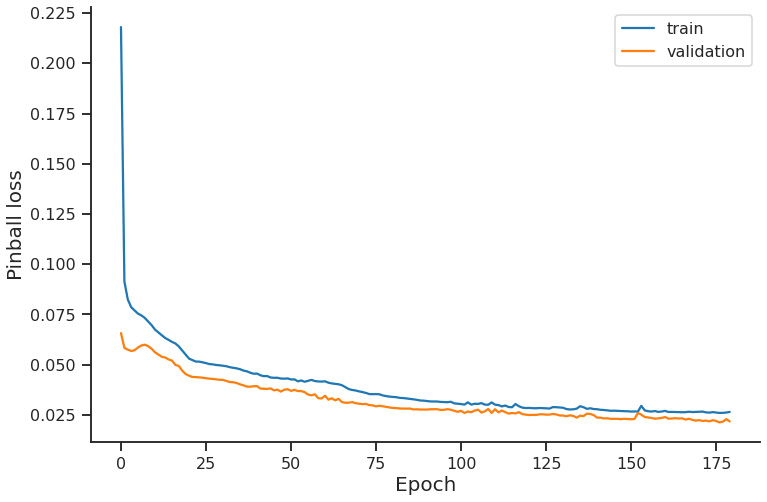

In [ ]:
sns.set_context("talk")
sns.set_style('ticks')
plt.figure(figsize=(12,8))
pyplot.plot(histories[3].history['loss'], label='train', color = 'tab:blue')
pyplot.plot(histories[3].history['val_loss'], label='validation', color = 'tab:orange')
plt.xlabel("Epoch", size=20)
plt.ylabel("Pinball loss", size=20)
pyplot.legend()
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1, 1))
#plt.savefig('fitting_q{}.png'.format(quantile))
sns.despine()
pyplot.show()

### Make predictions

In [ ]:
l_predictions = create_extract_predictions(test_X, models, quantiles)

In [ ]:
df_actual = extract_actual_values(test_y)

In [ ]:
accuracies = get_accuracies(df_actual, l_predictions, quantiles)

In [ ]:
accuracies.mean()

In [ ]:
accuracies.mean().mean()

0.45699636480319394

#### Calculate accuracies dependent on forecast horizon

In [ ]:
# Loss scores 2 hours ahead
l_2 = accuracies.iloc[7,:]
print('Scores per quantile:')
print(l_2)

# Average loss score 2 hours ahead
print('Average: ',l_2.mean())

Scores per quantile:
scores_quant_0.2    0.273537
scores_quant_0.4    0.393632
scores_quant_0.6    0.376034
scores_quant_0.8    0.261460
Name: 7, dtype: float64
Average:  0.32616566107495776


In [ ]:
# Loss scores 8 hours ahead
l_8 = accuracies.iloc[31,:]
print('Scores per quantile:')
print(l_8)

# Average loss score 8 hours ahead
print('Average: ',l_8.mean())

In [ ]:
# Loss scores 14 hours ahead
l_14 = accuracies.iloc[51,:]
print('Scores per quantile:')
print(l_14)

# Average loss score 14 hours ahead
print('Average: ',l_14.mean())

Scores per quantile:
scores_quant_0.2    0.410475
scores_quant_0.4    0.597115
scores_quant_0.6    0.555744
scores_quant_0.8    0.379761
Name: 51, dtype: float64
Average:  0.4857735689128947


In [ ]:
# Loss scores 20 hours ahead
l_20 = accuracies.iloc[79,:]
print('Scores per quantile:')
print(l_20)

# Average loss score 20 hours ahead
print('Average: ',l_20.mean())

Scores per quantile:
scores_quant_0.2    0.451282
scores_quant_0.4    0.721958
scores_quant_0.6    0.613735
scores_quant_0.8    0.457854
Name: 79, dtype: float64
Average:  0.5612071192217324


### Save results

In [ ]:
# Save predictions
with open("/content/drive/MyDrive/Colab Notebooks/lstm_predictions.txt", "wb") as fp:   #Pickling
    pickle.dump(l_predictions, fp)

In [ ]:
# Load predictions
#with open("C:/Users/alexl/Downloads/lstm_preds_first.txt", "rb") as fp:   #Pickling
#          l_pre = pickle.load(fp)

#### Plot final forecast

In [ ]:
# Create dataframe including predictions for several days
step = 1728
step2 = step + 96
step3 = step + 192
step4 = step + 288

days = 6
df_actual_predictions = DataFrame()
df_actual_predictions['q2'] = pd.Series(l_predictions[0].iloc[step, :].values)
df_actual_predictions['q4'] = pd.Series(l_predictions[1].iloc[step, :].values)
df_actual_predictions['q6'] = pd.Series(l_predictions[2].iloc[step, :].values)
df_actual_predictions['q8'] = pd.Series(l_predictions[3].iloc[step, :].values)
df_actual_predictions['actual'] = pd.Series(df_actual.iloc[step, :].values)

for i in range(days):
    position = step+(i+1)*96
    df_actual_predictions2 = DataFrame()
    df_actual_predictions2['q2'] = pd.Series(l_predictions[0].iloc[position, :].values)
    df_actual_predictions2['q4'] = pd.Series(l_predictions[1].iloc[position, :].values)
    df_actual_predictions2['q6'] = pd.Series(l_predictions[2].iloc[position, :].values)
    df_actual_predictions2['q8'] = pd.Series(l_predictions[3].iloc[position, :].values)
    df_actual_predictions2['actual'] = pd.Series(df_actual.iloc[position, :].values)
    df_actual_predictions = pd.concat ([df_actual_predictions, df_actual_predictions2])

periods = 96*(days+1)
df_actual_predictions['date'] = pd.date_range(start = '2019-01-15 00:00:00', periods = periods, freq = '15T')

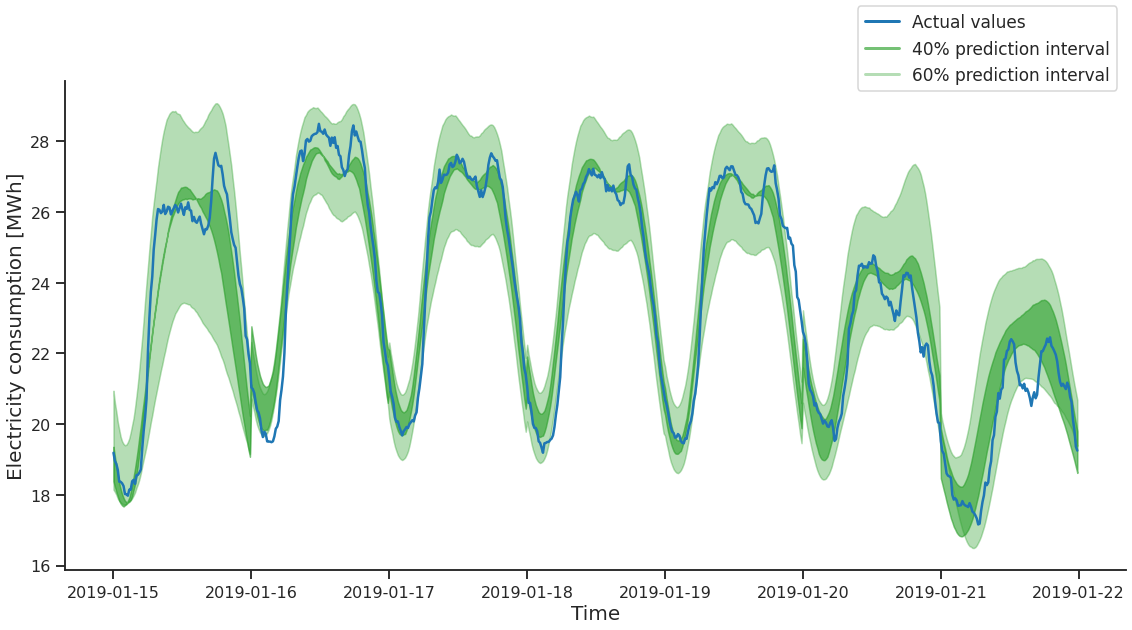

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(19,9))
#mpl.rcParams['font.family'] = 'Arial'

ax.plot(df_actual_predictions['date'], df_actual_predictions['actual'], color = 'tab:blue', linewidth = 2.5)
ax.fill_between(df_actual_predictions['date'], df_actual_predictions['q4'], df_actual_predictions['q6'], color = 'tab:green', alpha = 0.60)
ax.fill_between(df_actual_predictions['date'], df_actual_predictions['q2'], df_actual_predictions['q8'], color = 'tab:green', alpha = 0.35)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Electricity consumption [MWh]", fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

line1 = Line2D([0], [0], label = 'Actual values',color='tab:blue', linewidth = 3)
line2 = Line2D([0], [0], label = '40% prediction interval',color = 'tab:green', alpha = 0.65, linewidth = 3)
line3 = Line2D([0], [0], label = '60% prediction interval',color = 'tab:green', alpha = 0.35, linewidth = 3)

#ax.set(ylim=(0, 100))
plt.legend(handles=[line1, line2, line3],  fontsize=17 , bbox_to_anchor=(1, 1.17))
sns.despine()

### Indentify importance of variable temperature

In [ ]:
variable = 'temp' # can be exchanged with other variables
df_weather_rep.drop(columns = [variable], inplace = True)

In [ ]:
# split into standard days (atm 20%)
train_cons, test_cons = df_consumption.iloc[:35040,:], df_consumption.iloc[35040:, :]
train_weath, test_weath = df_weather_rep.iloc[:35040,:], df_weather_rep.iloc[35040:, :]

In [ ]:
# Define forecasting approach
n_in = 192
n_out = 96
n_vars = 5

# Load dataset
cons = train_cons.values
date_time = train_weath.iloc[:, 3:6]
weather = train_weath.iloc[:, 0:3].values

# Label encoding
encoder1 = LabelEncoder()
date_time_scaled = df_weather_rep.iloc[:, 3:6].apply(encoder1.fit_transform).values
date_time_scaled_train = date_time_scaled[:35040]
date_time_scaled_test =date_time_scaled[35040:]
date_time = date_time.astype('float32')

# Normalize features
scaler1 = MinMaxScaler()
scaled_consumption = scaler1.fit_transform(cons)
scaler2 = MinMaxScaler()
scaled_weather = scaler2.fit_transform(weather)

weather_all = hstack((scaled_weather, date_time_scaled_train))

# Create supervised learning dataset
reframed_train = series_to_supervised(scaled_consumption, weather_all, n_in, n_out)

In [ ]:
#Input numbers
n_out = 96
cons_hist = 192
other_vars = 6
n_in = cons_hist+other_vars

# split into train and test sets
values_train = reframed_train.values
train, val = values_train[:-6950, :], values_train[-6950:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_out], train[:, -n_out:]
val_X, val_y = val[:, :-n_out], val[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, int(train_X.shape[1]/n_in)))
val_X = val_X.reshape((val_X.shape[0], n_in, int(val_X.shape[1]/n_in)))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

# Combined train set
full_train_X, full_train_y = values_train[:, :-n_out], values_train[:, -n_out:]
full_train_X = full_train_X.reshape((full_train_X.shape[0], n_in, 1))

In [ ]:
# Test data
n_in = 192
n_out = 96
n_vars = 6

# load dataset
cons_test = test_cons
weather_test_s = test_weath.iloc[:, 0:3].values

# normalize features
scaled_consumption = scaler1.transform(cons_test)
scaled_weather = scaler2.transform(weather_test_s)
scaled = hstack((scaled_weather, date_time_scaled_test))

# frame as supervised learning
reframed_test = series_to_supervised(scaled_consumption, scaled, n_in, n_out)

print(reframed_test.head(1))

In [ ]:
#Input numbers
n_out = 96
cons_hist = 192
other_vars = 6
n_in = cons_hist+other_vars

# split into train and test sets
values_test = reframed_test.values

# split into input and outputs
test_X, test_y = values_test[:, :-n_out], values_test[:, -n_out:]


# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_in, int(test_X.shape[1]/n_in)))
print(test_X.shape, test_y.shape)

In [ ]:
quantiles = [0.2,0.4, 0.6, 0.8]
acts = list()
preds = list()
scores = list()
df_accuracies = DataFrame()
histories = list()
models = list()

for quantile in quantiles:
    model = build_model()
    model, history = fit_model(quantile, full_train_X, full_train_y, test_X, test_y, epoch = 180, batch_size = 768, verbose = 1)
    score = history.history.get('val_loss')[-1]
    scores.append(score)
    histories.append(history)

    models.append(model)
    
    # Plot train and validation error
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    print('Epochs: {}, Quantile: {}, Accuracy: {}'.format(i, quantile, score))

In [ ]:
l_predictions = create_extract_predictions(test_X, models, quantiles)
df_actual = extract_actual_values(test_y)
accuracies = get_accuracies(df_actual, l_p, quantiles)
accuracies.mean()
accuracies.mean().mean()

Removed variables and precentage change:
- Accuracy after removing temperature: 1.051, decrease in accuracy by -145% (1.051-0.4276/0.4276)

- Accuracy without the feature wind speed: 0.6874 -> percentage decrease of 20%

- Accuracy without the feature cloud cover: 0.9984 -> percentage decrease by 130%